In [1]:
import os
import numpy as np
from matplotlib import ticker, dates as mdates, pyplot as plt
from pysar.objects import sensor
from pysar.utils import readfile, writefile, ptime, plot as pp
from pysar.simulation.plot import *


work_dir = '/Users/yunjunz/development/python/2018_ComputGeosci_PySAR/pixelwise_geometry4dem_error'

proj_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/PIXELWISE_GEOMETRY'
proj_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosAlosAT133/PYSAR/PIXELWISE_GEOMETRY'
proj_name = sensor.project_name2sensor_name(proj_dir)[1]

run_pysar_cmd = False
if run_pysar_cmd:
    os.chdir(proj_dir)
    print('Go to directory: '+proj_dir)

    # with pixelwise geometry
    cmd = 'dem_error.py timeseries_ECMWF.h5 -g ../INPUTS/geometryRadar.h5 -t pysarApp_template.txt'
    cmd += '\nmv demErr.h5 demErr_pixelGeom.h5'
    print(cmd)
    os.system(cmd)

    # with mean geometry
    cmd = 'dem_error.py timeseries_ECMWF.h5 -t pysarApp_template.txt'
    cmd += '\nmv demErr.h5 demErr_meanGeom.h5'
    cmd += '\ndiff.py demErr_pixelGeom.h5 demErr_meanGeom.h5 -o demErr_diffGeom.h5'
    print(cmd)
    os.system(cmd)

os.chdir(work_dir)
print('go to directory: '+work_dir)

go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/pixelwise_geometry4dem_error


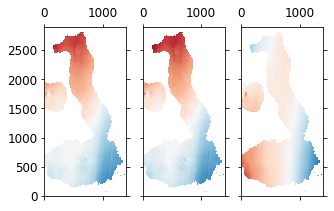

In [2]:
# plot

fnames = [os.path.join(proj_dir, i) for i in ['demErr_pixelGeom.h5',
                                              'demErr_meanGeom.h5',
                                              'demErr_diffGeom.h5']]
atr = readfile.read_attribute(fnames[0])
length, width = int(atr['LENGTH']), int(atr['WIDTH'])
box = (0, 800, width, 3700)

de_data = np.zeros((len(fnames), box[3]-box[1], box[2]-box[0]), np.float32)
for i in range(len(fnames)):
    data = readfile.read(fnames[i], box=box)[0]
    data[data == 0.] = np.nan
    de_data[i, :, :] = data
vlim1 = (np.)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(5, 6), sharex=True, sharey=True)
for i in range(len(fnames)):
    axi = ax[i]
    axi.imshow(de_data[i], cmap='RdBu')
    axi.invert_yaxis()
    axi.xaxis.tick_top()
    axi.tick_params(which='both', direction='out', labelsize=font_size,
                    bottom=True, top=True, left=True, right=True)


out_file = 'pixel_geom4dem_{}.jpg'.format(proj_name)
#plt.savefig(out_file, bbox_inches='tight', dpi=fig_dpi)
plt.show()